<a href="https://colab.research.google.com/github/Akshat-works/Vision-Transformer/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
num_classes = 10
input_shape = (32,32,3)
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
input_shape = (32,32,3)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72 #We will resize the images
patch_size = 6 #Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
  projection_dim*2,
  projection_dim
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.Normalization(trainable=False),
  layers.Resizing(image_size, image_size),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(factor=0.02),
  layers.RandomZoom(
    height_factor = 0.2,
    width_factor = 0.2
  )
  ],
  name="data_augmentation"
)
data_augmentation.layers[0].adapt(X_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
      images = images,
      sizes = [1, self.patch_size, self.patch_size, 1],
      strides = [1, self.patch_size, self.patch_size, 1],
      rates = [1, 1, 1, 1],
      padding = "VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image size: 72 X 72
Patch_size: 6 X 6
Patches per image: 144
Elements per patch: 108


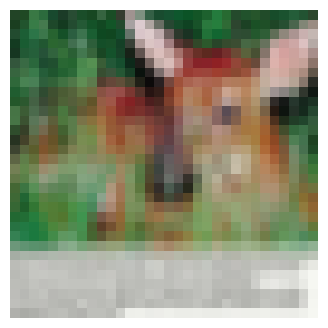

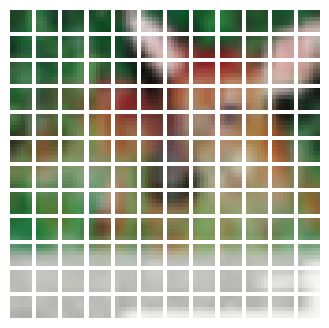

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
  tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch_size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder,self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )
  def call(self,patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded =self.projection(patch) + self.position_embedding(positions)
    return encoded

In [ ]:
def create_vit_classifier():
  inputs = layers.Input(shape=input_shape)
  #Augment data.
  augmented = data_augmentation(inputs)
  #create patches
  patches = Patches(patch_size)(augmented)
  #encode patches.
  encoded_patches = PatchEncoder(num_patches,projection_dim)(patches)

  #create multiple layers of the transformer block
  for _ in range(transformer_layers):
    #layer normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #create a multi-head attention layer
    attention_output = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1,x1)
    #skip connection1
    x2 = layers.Add()([attention_output,encoded_patches])
    #layer normalization2
    x3= layers.LayerNormalization(epsilon=1e-6)(x2)
    #MlP
    x3 = mlp(x3, hidden_units = transformer_units, dropout_rate=0.1)
    #skipconnection2.
    encoded_patches = layers.Add()([x3,x2])

  #create a [batch_size , projection_dim]tensor

  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)
  #add mlp.
  features = mlp(representation,hidden_units=mlp_head_units, dropout_rate=0.5)
  #classify outputs.
  logits = layers.Dense(num_classes)(features)
  #create the Keras Model
  model = keras.models.Model(inputs=inputs, outputs=logits)
  return model

In [ ]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
  )
  model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
      keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
      keras.metrics.SparseTopKCategoricalAccuracy(5,name="top-5-accuracy"),
    ],
  )

  checkpoint_filepath = "./temp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
  )
  history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[checkpoint_callback]
  )
  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
  print(f"Test accuracy: {round(accuracy*100,2)}%")
  print(f"Test Top 5 accuracy:{round(top_5_accuracy*100,2)}%")

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
176/176 [==============================] - 82s 388ms/step - loss: 2.0881 - accuracy: 0.3050 - top-5-accuracy: 0.7970 - val_loss: 1.5233 - val_accuracy: 0.4556 - val_top-5-accuracy: 0.9114
Epoch 2/40
176/176 [==============================] - 72s 407ms/step - loss: 1.5871 - accuracy: 0.4305 - top-5-accuracy: 0.8941 - val_loss: 1.2943 - val_accuracy: 0.5392 - val_top-5-accuracy: 0.9406
Epoch 3/40
176/176 [==============================] - 74s 419ms/step - loss: 1.4196 - accuracy: 0.4920 - top-5-accuracy: 0.9237 - val_loss: 1.2215 - val_accuracy: 0.5528 - val_top-5-accuracy: 0.9558
Epoch 4/40
176/176 [==============================] - 74s 419ms/step - loss: 1.3203 - accuracy: 0.5306 - top-5-accuracy: 0.9349 - val_loss: 1.1121 - val_accuracy: 0.6056 - val_top-5-accuracy: 0.9594
Epoch 5/40
176/176 [==============================] - 74s 419ms/step - loss: 1.2420 - accuracy: 0.5605 - top-5-accuracy: 0.9440 - val_loss: 1.0393 - val_accuracy: 0.6314 - val_top-5-accuracy: 0.9688
Epoch

In [ ]:
class_names = [
    'airplane'
    'automobile'
    'bird'
    'cat'
    'deer'
    'dog'
    'frog'
    'horse'
    'ship'
    'truck'
]

In [ ]:
def img_predict(images, model):
  if len(images.shape) == 3:
    out = model.predict(images.reshape(-1,*images.shape))
  else:
    out = model.predict(images)
  prediction = np.argmax(out, axis = 1)
  img_prediction = []
  for i in prediction:
    if i <= len(class_names):
      img_prediction.append(class_names[i])
    else:
      img_prediction.append("Unknown")
  return img_prediction

1/1 [==============================] - 1s 1s/step
['Unknown']


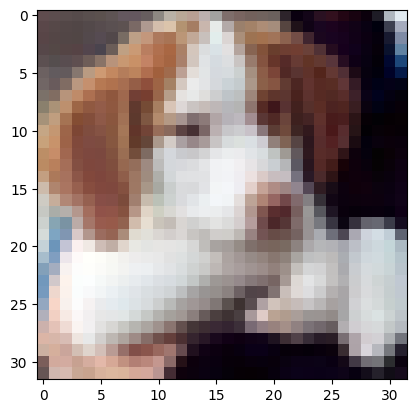

In [ ]:
index=16
plt.imshow(X_test[index])
prediction=img_predict(X_test[index],vit_classifier)
print(prediction)